# PyLIMA Example

In this notebook we look at how we can import and use models from the [pyLIMA package](https://github.com/ebachelet/pyLIMA), a package for simulating and analyzing gravitational lensing effects.  

Note that the pyLima package is not installed as part of the default LightCurveLynx installation. Users will need to manually install them via pip (e.g. `pip install pyLIMA`) in order to run this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.pylima_models import PyLIMAWrapperModel
from lightcurvelynx.utils.plotting import plot_lightcurves

## Create the Survey Data

There are two types of data files we need to run a LightCurveLynx simulation an `ObsTable` and passband information. In most cases we will want to load the simulated or actual observation tables from various surveys.

In this example we will use the default Rubin passbands. But we will create a fake observation cadence that is better for visualizing microlensing events. Specifically, we will take make two fake `OpSim` that observes the exact same location on the sky (45.0, -20.0) three times a night, once in each of the 'r", "g", and 'i' bands.

Note that we specify a lot of noise parameters with the fake `OpSim`, but in normal cases users will be loading a predefined opsim with all of that information pre-populated.

In [2]:
filters = ["g", "r", "i"]
passband_group = PassbandGroup.from_preset(preset="LSST", filters=filters)

num_days = 50
mjd_start = 60676.0
mjd_end = mjd_start + num_days

num_samples = 500
survey_data = {
    "observationStartMJD": np.linspace(mjd_start, mjd_end, num_samples),
    "fieldRA": np.full(num_samples, 45.0),
    "fieldDec": np.full(num_samples, -20.0),
    "zp_nJy": np.random.normal(loc=1.0, scale=0.1, size=num_samples),
    "filter": [filters[i % 3] for i in range(num_samples)],
    "seeing": np.random.normal(loc=1.1, scale=0.1, size=num_samples),
    "skybrightness": np.random.normal(loc=20.0, scale=0.1, size=num_samples),
    "exptime": np.full(num_samples, 30.0),
    "nexposure": np.full(num_samples, 2),
}
obs_table = OpSim(survey_data)

## Create the model

Next we want to create a model of the physical phenomena that we would like to simulation (in this case pyLIMA microlensing models). There are a variety of settable parameters we can set for these models depending on the type of models.

Let's set the time and positions parameters based on the survey:

* RA drawn uniformly from [44.0, 46.0]
* DEC drawn uniformly from [-19.0, -21.0]
* T0 drawn uniformly from the time range of our survey [60676.0, 60776.0]

Since the field of view of a Rubin observation has a radius of 1.75 degrees, we can sample RA and DEC for our observations from a small region around the center of the image and know they will show up in all the images. 

Internally, these parameters will be used to create a PyLIMA event for the actual simulation. However the wrapper model hides that complexity from the user. We just need to specify values or distributions for the parameters.

In [3]:
ra_sampler = NumpyRandomFunc("uniform", low=44.0, high=46.0)
dec_sampler = NumpyRandomFunc("uniform", low=-21.0, high=-19.0)
t0_sampler = NumpyRandomFunc("uniform", low=mjd_start, high=mjd_end)

In addition to those parameters, PyLIMA models come with a large number of their own settable parameters that vary with the simulation options. For concreteness, lets use a PSPL model with the following settings:

- Full Parallax
- Flux blending type of "gblend" 
- No double source
- No orbital motion

Given those options the required parameters include:

- Already specified parameters (`t0`)
- New model specific parameters (`u0`, `tE`, `piEN`, `piEE`)
- Source flux values for each filter (`fsource_r`, `fsource_g`, …). These are specified to the model as magnitudes.
- Blend flux values for each filter (`fblend_r`, `fblend_g`, …). The names of these can vary depending on the blending used.

For the source and blend flux values, you provide a *magntiude* per filter. LightCurveLynx automatically handles the conversion to flux and appending the parameter's prefix. To demonstrate the different ways we can set parameters, we use a mixture of distributions (e.g. source_mags) and fixed values (e.g. blend_mags).

In [4]:
# Use a fixed piEN and piEE and random values for u0 and tE
pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.1),
    "tE": NumpyRandomFunc("uniform", low=20.0, high=30.0),
    "piEN": 0.1,
    "piEE": 0.1,
}

# Both the source and blend amounts are specified as magnitudes in each filter.
# LightCurveLynx handles both the conversion from magnitudes to fluxes and
# the addition of the correct parameter prefix.
source_mags = {
    "g": 22.0 + np.random.normal(scale=0.3),
    "r": 21.5 + np.random.normal(scale=0.3),
    "i": 21.2 + np.random.normal(scale=0.3),
}
blend_mags = {
    "g": 24.5,
    "r": 24.0,
    "i": 23.8,
}

We can now create the actual model object. We pass the name of the model, the dictionary of source magnitudes, and the (optional) dictionary of blend magnitudes directly. If no blend magnitudes are provided, LightCurveLynx will default to a flux of 0.0. We pass the setters (distributions or values) of the core physical model parameters (`ra`, `dec`, `t0`) as keyword arguments. We also pass model specification information (`parallax_model` and `blend_flux_parameter`) as keyword arguments. Finally we pass the model specific parameters either as a dictionary (`pylima_params`) or as keyword arguments (as we did with `t0`).

In [5]:
source = PyLIMAWrapperModel(
    "PSPL",  # Model type
    source_mags=source_mags,  # Dictionary of filter to a magnitude distribution
    blend_mags=blend_mags,  # Dictionary of filter to a magnitude values
    ra=ra_sampler,  # Sample RA from uniform distribution
    dec=dec_sampler,  # Sample Dec from uniform distribution
    t0=t0_sampler,  # Sample t0 from uniform distribution
    parallax_model="Full",  # Use full parallax model
    blend_flux_parameter="fblend",  # Use fblend
    pylima_params=pylima_params,  # Additional PyLIMA parameters
    node_label="source",  # A node name for convenience
)

Almost all of the parameters are randomly sampled. Let's look at a sampling.

In [6]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["source"].items():
    print(f"{key}: {val}")

ra: 44.75508424595852
dec: -19.968296936085
redshift: None
t0: 60707.28499547905
distance: None
fsource_g: 6546.546630806502
fsource_r: 11935.914991807877
fsource_i: 8145.385077450264
fblend_g: 575.4399373371566
fblend_r: 912.0108393559087
fblend_i: 1096.478196143183
u0: 0.012220004642094735
tE: 21.66710227715626
piEN: 0.1
piEE: 0.1


If we sample again, we get different values.

In [7]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["source"].items():
    print(f"{key}: {val}")

ra: 44.6692445640937
dec: -19.47984324490503
redshift: None
t0: 60692.542747282816
distance: None
fsource_g: 6546.546630806502
fsource_r: 11935.914991807877
fsource_i: 8145.385077450264
fblend_g: 575.4399373371566
fblend_r: 912.0108393559087
fblend_i: 1096.478196143183
u0: 0.06308504099584479
tE: 29.633111962136105
piEN: 0.1
piEE: 0.1


## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes four parameters: the source from which we want to sample (here the collection of lightcurves), the number of results to simulate (100), the opsim, and the passband information.

We use the `time_window_offset` parameter to limit the samples for each object to 10 days before and 50 days after that object's `t0`. These bounds are provided in the observer frame.

In [8]:
lightcurves = simulate_lightcurves(
    source,
    100,
    obs_table,
    passband_group,
)

Simulating: 100%|██████████| 100/100 [00:05<00:00, 17.83obj/s]


The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.  We can treat it as a (nested) table.

Let's look at the lightcurve for the first object sampled:

In [9]:
print(lightcurves.loc[0]["lightcurve"])

            mjd filter          flux     fluxerr  flux_perfect  survey_idx  \
0    60676.0000      g  34306.968958  357.521589  34824.556104           0   
1    60676.1002      r  64363.527713  401.032200  64373.928945           0   
..          ...    ...           ...         ...           ...         ...   
498  60725.8998      g   7922.988970  312.139751   7765.944898           0   
499  60726.0000      r  14464.993479  386.429546  14014.866754           0   

     obs_idx  is_saturated  
0          0         False  
1          1         False  
..       ...           ...  
498      498         False  
499      499         False  

[500 rows x 8 columns]


Let's see where we generated the observations by using the results RA and dec columns. As expected the are within a box in the center of the field of view.

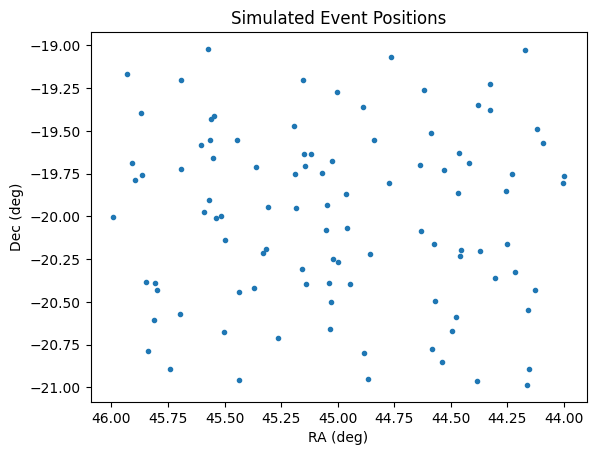

In [10]:
plt.plot(lightcurves["ra"], lightcurves["dec"], ".")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.gca().invert_xaxis()
plt.title("Simulated Event Positions")
plt.show()

Now let's plot the first few lightcurves to see what they look like when observed via Rubin's cadence.

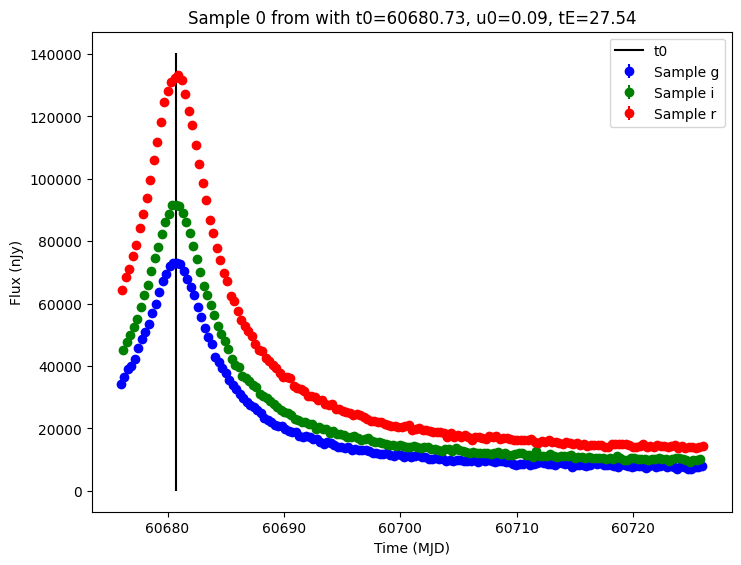

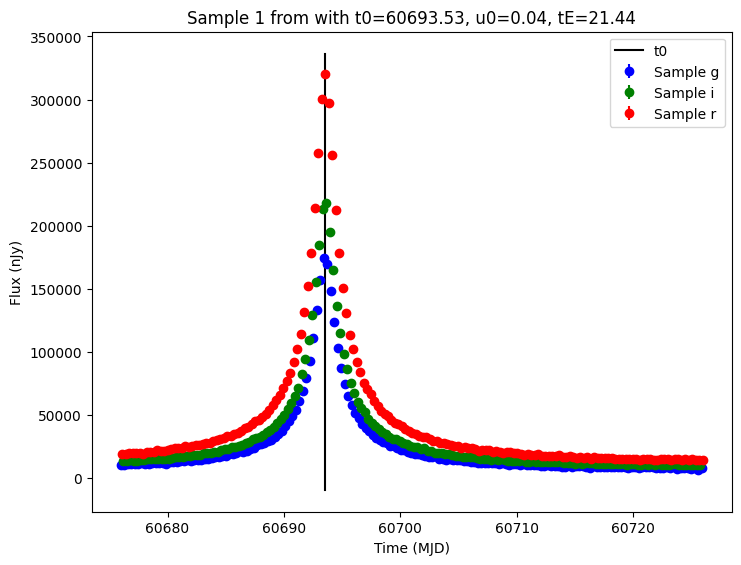

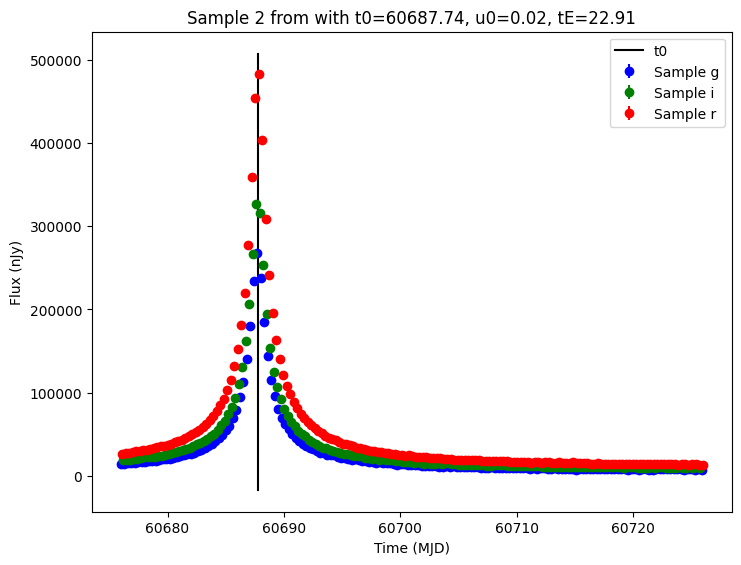

In [11]:
for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Get information about the sampled parameter values for the plot's title.
    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Sample {idx} from with t0={t0:.2f}, u0={u0:.2f}, tE={tE:.2f}",
    )
    ax.plot([t0, t0], ax.get_ylim(), "k-", label="t0")
    ax.legend()
    plt.show()

## Other Models

We can simulate types of microlesing events, such as Finite-Source Point-Lens (FSPL), by providing a different model name and the required parameters. It is important to note that each model type may have different required parameters. For example, the FSPL model needs a `rho` parameter.

In [12]:
# FSPL needs rho
fspl_source = PyLIMAWrapperModel(
    "FSPLarge",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="Full",
    blend_flux_parameter="fblend",
    pylima_params={
        **pylima_params,
        "rho": NumpyRandomFunc("uniform", low=1e-4, high=5e-3),
    },
    node_label="source",
)

fspl_lightcurves = simulate_lightcurves(
    fspl_source,
    3,
    obs_table,
    passband_group,
)

Simulating: 100%|██████████| 3/3 [00:00<00:00, 17.81obj/s]


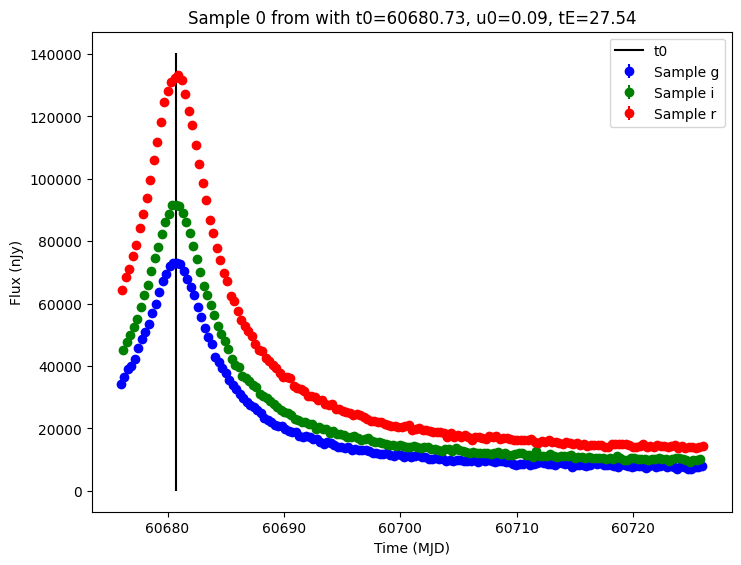

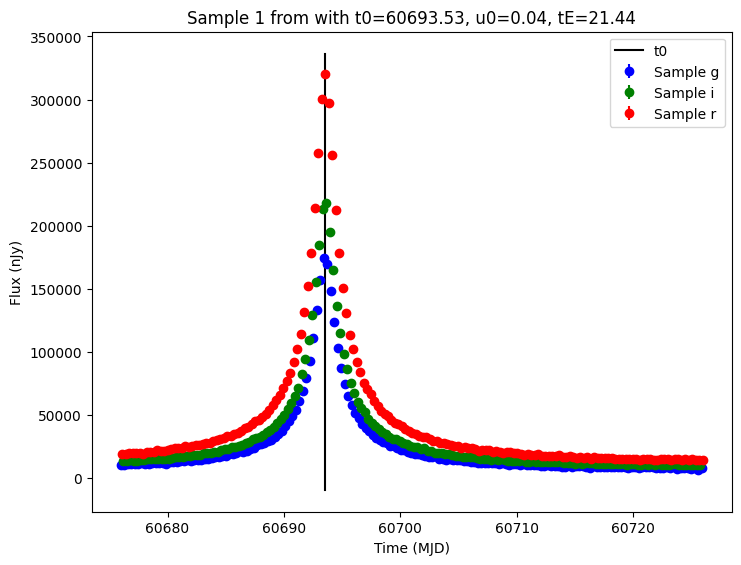

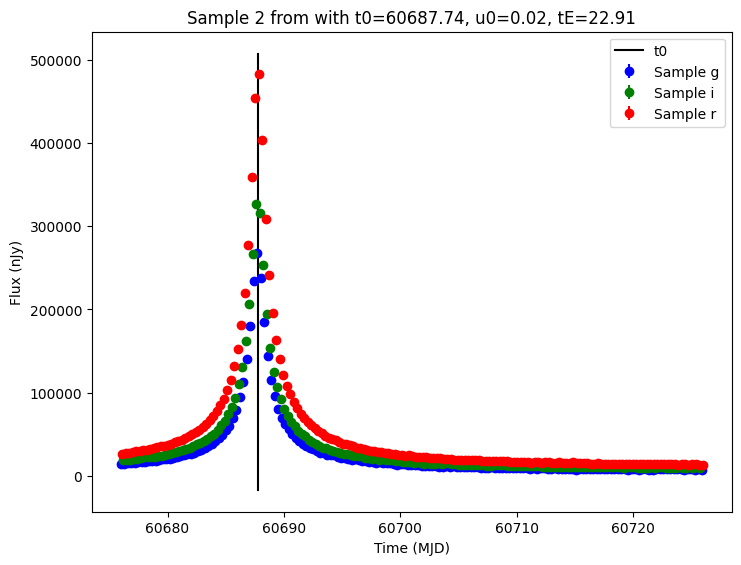

In [13]:
for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Get information about the sampled parameter values for the plot's title.
    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Sample {idx} from with t0={t0:.2f}, u0={u0:.2f}, tE={tE:.2f}",
    )
    ax.plot([t0, t0], ax.get_ylim(), "k-", label="t0")
    ax.legend()
    plt.show()